In [9]:
import cupy as cp

# Use numpy instead of cupy if you don't have a GPU
def relu(x):
    return cp.maximum(0, x)

def relu_derivative(x):
    return cp.where(x > 0, 1, 0)

def softmax(x):
    e_x = cp.exp(x - cp.max(x, axis=1, keepdims=True))
    return e_x / cp.sum(e_x, axis=1, keepdims=True)

def cross_entropy_loss(predictions, targets):
    return -cp.sum(targets * cp.log(predictions + 1e-9)) / targets.shape[0]

def cross_entropy_loss_with_regularization(predictions, targets, weights, reg_lambda):
    loss = cross_entropy_loss(predictions, targets)
    reg_loss = 0.5 * reg_lambda * sum(cp.sum(w**2) for w in weights)
    return loss + reg_loss

def predict(x, weights, biases):
    a = x
    for i in range(len(weights) - 1):
        a = relu(cp.dot(a, weights[i].T) + biases[i])
    a = softmax(cp.dot(a, weights[-1].T) + biases[-1])
    return cp.argmax(a, axis=1, dtype=int)

def initialize_parameters(layers):
    cp.random.seed(42)
    weights = []
    biases = []
    for i in range(len(layers) - 1):
        limit = cp.sqrt(6 / (layers[i] + layers[i + 1]))
        weights.append(cp.random.uniform(-limit, limit, (layers[i + 1], layers[i])))
        biases.append(cp.zeros(layers[i + 1]))
    return weights, biases

def forward_propagation(x, weights, biases):
    activations = [x]
    pre_activations = []
    a = x
    for i in range(len(weights) - 1):
        z = cp.dot(a, weights[i].T) + biases[i]
        pre_activations.append(z)
        a = relu(z)
        activations.append(a)
    z = cp.dot(a, weights[-1].T) + biases[-1]
    pre_activations.append(z)
    a = softmax(z)
    activations.append(a)
    return pre_activations, activations

def backward_propagation(x, y, weights, biases, pre_activations, activations, reg_lambda):
    m = x.shape[0]
    grads_weights = [cp.zeros_like(w) for w in weights]
    grads_biases = [cp.zeros_like(b) for b in biases]
    
    delta = activations[-1] - y
    grads_weights[-1] = cp.dot(delta.T, activations[-2]) / m + reg_lambda * weights[-1]
    grads_biases[-1] = cp.sum(delta, axis=0) / m

    for i in range(len(weights) - 2, -1, -1):
        delta = cp.dot(delta, weights[i + 1]) * relu_derivative(pre_activations[i])
        grads_weights[i] = cp.dot(delta.T, activations[i]) / m + reg_lambda * weights[i]
        grads_biases[i] = cp.sum(delta, axis=0) / m

    return grads_weights, grads_biases

def load_mnist():
    from tensorflow.keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = cp.asarray(x_train.reshape(-1, 784) / 255.0)
    x_test = cp.asarray(x_test.reshape(-1, 784) / 255.0)
    y_train = cp.eye(10)[y_train]
    y_test = cp.eye(10)[y_test]
    return x_train, y_train, x_test, y_test

def train(x_train, y_train, weights, biases, eta, epochs, reg_lambda, decay_rate=0.95, decay_epoch=100):
    for epoch in range(epochs):
        pre_activations, activations = forward_propagation(x_train, weights, biases)
        loss = cross_entropy_loss_with_regularization(activations[-1], y_train, weights, reg_lambda)
        grads_weights, grads_biases = backward_propagation(x_train, y_train, weights, biases, pre_activations, activations, reg_lambda)
        
        for i in range(len(weights)):
            weights[i] -= eta * grads_weights[i]
            biases[i] -= eta * grads_biases[i]
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

        # Decay the learning rate
        if (epoch + 1) % decay_epoch == 0:
            eta *= decay_rate

    return weights, biases

if __name__ == "__main__":
    x_train, y_train, x_test, y_test = load_mnist()
    layers = [784, 128, 64, 32, 10]
    eta = 0.1
    epochs = 500
    lambdas = [0.001, 0.002, 0.005, 0.01, 0.02]
    best_accuracy = 0
    best_params = None

    for reg_lambda in lambdas:
        weights, biases = initialize_parameters(layers)
        weights, biases = train(x_train, y_train, weights, biases, eta, epochs, reg_lambda)
        predictions = predict(x_test, weights, biases)
        test_labels = cp.argmax(y_test, axis=1)
        accuracy = cp.mean(predictions == test_labels)
        print(f"Test Accuracy: {accuracy * 100:.2f}% with lambda = {reg_lambda}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (weights, biases)

    print(f"Best Test Accuracy: {best_accuracy * 100:.2f}%")

Epoch 100, Loss: 0.5936
Epoch 200, Loss: 0.4939
Epoch 300, Loss: 0.4488
Epoch 400, Loss: 0.4196
Epoch 500, Loss: 0.3979
Test Accuracy: 94.05% with lambda = 0.001
Epoch 100, Loss: 0.8150
Epoch 200, Loss: 0.6754
Epoch 300, Loss: 0.6250
Epoch 400, Loss: 0.5909
Epoch 500, Loss: 0.5647
Test Accuracy: 93.91% with lambda = 0.002
Epoch 100, Loss: 1.3268
Epoch 200, Loss: 1.1480
Epoch 300, Loss: 1.0574
Epoch 400, Loss: 0.9877
Epoch 500, Loss: 0.9306
Test Accuracy: 93.49% with lambda = 0.005
Epoch 100, Loss: 2.1141
Epoch 200, Loss: 1.7393
Epoch 300, Loss: 1.5289
Epoch 400, Loss: 1.3690
Epoch 500, Loss: 1.2428
Test Accuracy: 92.58% with lambda = 0.01
Epoch 100, Loss: 3.2198
Epoch 200, Loss: 2.4011
Epoch 300, Loss: 1.9206
Epoch 400, Loss: 1.6035
Epoch 500, Loss: 1.3906
Test Accuracy: 90.75% with lambda = 0.02
Best Test Accuracy: 94.05%


TypeError: argmax() got an unexpected keyword argument 'dtype'

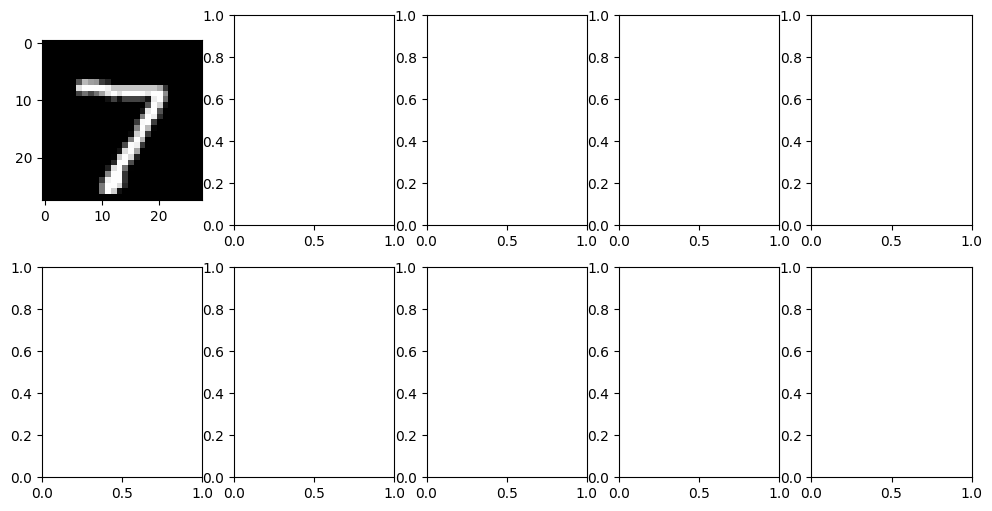

In [11]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

weights, biases = 

predicted = predict(x_test, )

for i in range(10):
    axes[i].imshow(x_test_cpu[i], cmap='gray')
    true_label = cp.argmax(y_test_cpu[i])
    pred_label = predicted[i]
    axes[i].set_title(f"True: {true_label}, Pred: {pred_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
